Inspired by Matejka and Fitzmaurice's work: ["
Same Stats, Different Graphs: Generating Datasets with Varied Appearance and Identical Statistics through Simulated Annealing"](https://www.autodeskresearch.com/publications/samestats)
<img src="https://d2f99xq7vri1nk.cloudfront.net/DataDino-600x455.gif" width="200" />

Using the method described in [Animation with Identical Statistics](Animation with Identical Statistics.ipynb) (ZCA/minumum weight matching)

In [1]:
# load the image
from PIL import Image
import numpy as np
from IPython.display import display
def get_dots(fn, size=(160,160), n_dots=500, box=None):
    # replace transparent background with white
    img = np.array(Image.open(fn).convert('RGBA'))
    if box is not None:
        img = img[box[1]:box[3], box[0]:box[2]]
    img[img[:,:,3]==0]=[255,255,255,255]    
    img = Image.fromarray(img).convert('L')
    img.thumbnail(size, Image.ANTIALIAS)
    display(img)
    # Use the image as a probability distribution
    a = 255 - np.array(img)
    prob = (a/a.sum()).ravel()
    # sampling from coordinate
    y, x = np.unravel_index(np.random.choice(a.size, n_dots, replace=True, p=prob), a.shape)
    return (x, a.shape[0]-y-1)

In [2]:
def ZCA(X):
    """ZCA whitening
        adapt from keras source code, 
        https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py
    """
    X = (X - X.mean(axis=0))
    Σ = X.T @ X / X.shape[0]
    U, Λ, _ = np.linalg.svd(Σ)
    principal_components = U @ np.diag(1./np.sqrt(np.abs(Λ))) @ U.T
    return X @ principal_components


In [3]:
# mini match greedy matching
def match_idx(A, B, batch=50):
    assert len(A)%(batch)==0
    assert len(A) == len(B)
    A_rtn_idx = np.zeros(len(A), dtype='int32')
    B_rtn_idx = np.zeros(len(B), dtype='int32')
    A_left_idx = np.linalg.norm(A, axis=1).argsort()[::-1]
    B_left_idx = np.linalg.norm(B, axis=1).argsort()[::-1]
    A = A[A_left_idx]
    B = B[B_left_idx]
    for i in range(0, len(A), batch):
        #print("i=", i)
        if (i//batch)%2== 0:
            # A -> B
            a = A[:batch]
            b = B
        else:
            a = A
            b = B[:batch]
        C = scipy.spatial.distance.cdist(a, b)
        a_idx, b_idx = scipy.optimize.linear_sum_assignment(C)
        A_rtn_idx[i:i+batch] = A_left_idx[a_idx]
        B_rtn_idx[i:i+batch] = B_left_idx[b_idx]
        A = np.delete(A, a_idx, axis=0)
        A_left_idx = np.delete(A_left_idx, a_idx)
        B = np.delete(B, b_idx, axis=0)
        B_left_idx = np.delete(B_left_idx, b_idx) 
    return A_rtn_idx, B_rtn_idx


In [4]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt
rc('animation', html='html5')
fig = plt.gcf()
fig.set_size_inches(12,10)
plt.xlim(-3, 3)
plt.ylim(-2.5,2.5)
fig = plt.gcf()
scatters = plt.scatter([],[], alpha=0.6, color='k', s=16)
label_text = plt.text(1.35,1.5,"""
X Mean
X SD  
Y Mean
Y SD 
Corr.""", size=24, color="#558855")

stat_text = plt.text(2.,1.5,"""
: 0
: 0
: 0
: 0
: 0""",size=24, color="#009900")
plt.subplots_adjust(top = 1,  right = 1, bottom=0, left=0, hspace=0, wspace=0)
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('g')
ax.spines['bottom'].set_position('center')
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('r')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.margins(0,0)
plt.ioff()

In [5]:
# an helper function to see matplotlib animation with ipywidgets
# helpful for adjusting the plot
import ipywidgets
from IPython.display import display
import time
from io import BytesIO
def show_anim(anim, loops=1):
    img=ipywidgets.Image(width=800)
    display(img)
    for i in range(loops):
        target_time = time.time() + anim._interval/1000
        for d in anim.new_saved_frame_seq():    
            anim._draw_next_frame(d, blit=False)
            with BytesIO() as bio:
                fig.savefig(bio, format="png")
                img.value = bio.getvalue()
            now = time.time()
            if target_time > now:
                time.sleep(target_time-now)
            target_time += anim._interval/1000

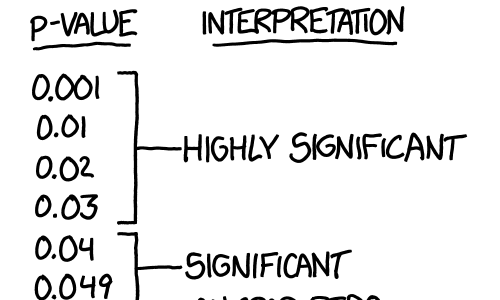

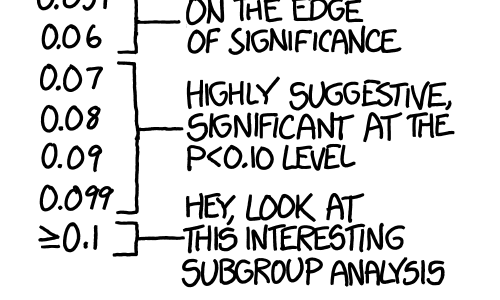

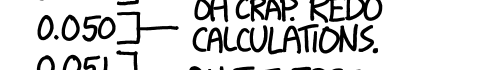

In [6]:
# load and process all images 
import glob
import random
params= dict(n_dots=6000, size=(500,500))
def G(f, b):
    img = get_dots(f, box=b, **params)
    return ZCA(np.float64(img).T)

p0 = get_dots("xkcd/p_values_2x.png", box=(10,30,510,330), n_dots=6000, size=(5000,5000))
p1 = get_dots("xkcd/p_values_2x.png", box=(10,400,510,700), n_dots=6000, size=(5000,5000))
p2 = get_dots("xkcd/p_values_2x.png", box=(10,330,510,400), n_dots=1500, size=(5000,5000))
p = np.concatenate([np.float64(p0).T+[0,370], np.float64(p2).T +[0,300], np.float64(p1).T], axis=0)
def p_values(t):
    y = np.clip(int(370-370*t), 0,370)
    return p[(p[:,1] >= y) & (p[:,1] <y+300)]

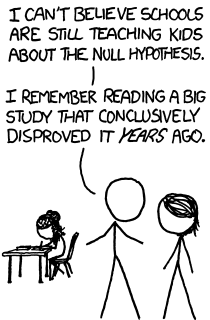

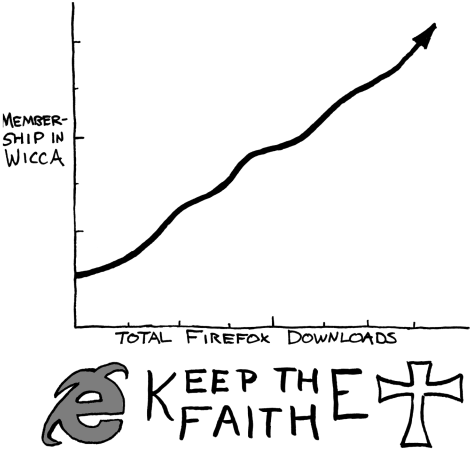

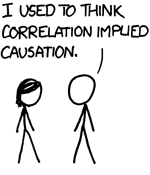

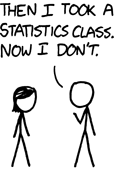

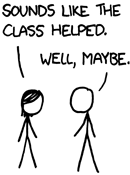

In [7]:
img_list = [
    G("xkcd/null_hypothesis.png", (10,10,220,330)),
    G("xkcd/firefox_wicca.png", (10,10,480,460)),
    ZCA(p_values(0)),
    ZCA(p_values(1)),
    G("xkcd/correlation.png", (5,5,155,180)),
    G("xkcd/correlation.png", (180,5,300,180)),
    G("xkcd/correlation.png", (320,5,450,180)),
]

In [8]:
# compute all interpolation functions, this will take several minutes.
import scipy
import scipy.interpolate
import scipy.spatial
import scipy.optimize
img_list=img_list[3:]+img_list[:3]
funcs = []
for s, t in zip(img_list[:-1], img_list[1:]):    
    t0 = time.time()
    s_idx, t_idx = match_idx(s,t, 50)
    funcs.append(scipy.interpolate.interp1d([0,1], [s[s_idx], t[t_idx]], axis=0))
    print("done", time.time()-t0, len(funcs), len(img_list)-1)
    

done 20.373849153518677 1 6
done 15.962248086929321 2 6
done 17.232692003250122 3 6
done 19.47302746772766 4 6
done 28.193501472473145 5 6
done 28.69503426551819 6 6


In [9]:
funcs=funcs[4:]+[p_values]+funcs[:4]
img_list=img_list[4:]+img_list[:4]

Construct the animation

In [12]:
import scipy.stats
T =120
def animate(tick):
    if tick%T < T-30:
        X = img_list[tick//T]
    else:
        f = funcs[tick//T]
        X = f((tick+30)%T/30)
        X = ZCA(X)
    scatters.set_offsets([X])
    stat_text.set_text("""
: {:8.5f}
: {:8.5f}
: {:8.5f}
: {:8.5f}
: {:8.5f}""".format(X[:,0].mean(), 
           X[:,0].std(), 
           X[:,1].mean(), 
           X[:,1].std(), 
           scipy.stats.pearsonr(X[:,0], X[:,1])[0]))
    return [scatters, stat_text]
anim = animation.FuncAnimation(fig, animate, frames=T*len(funcs), interval=1000/30, blit=True)

In [13]:
# Encoding the video might take minutes
anim